In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import Tensor
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications import ResNet50, MobileNetV2

import os
import splitfolders
import glob

import warnings
warnings.filterwarnings('ignore')

2025-09-06 13:52:20.273372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
FILE_PATH = './img'

In [3]:
splitfolders.ratio(FILE_PATH, output = 'output', seed = 42, ratio = (0.8, 0.1, 0.1))

train_path = './output/train'
test_path = './output/test'
val_path = './output/val'


class_name = os.listdir(train_path)
class_test = os.listdir(test_path)
class_val = os.listdir(val_path)


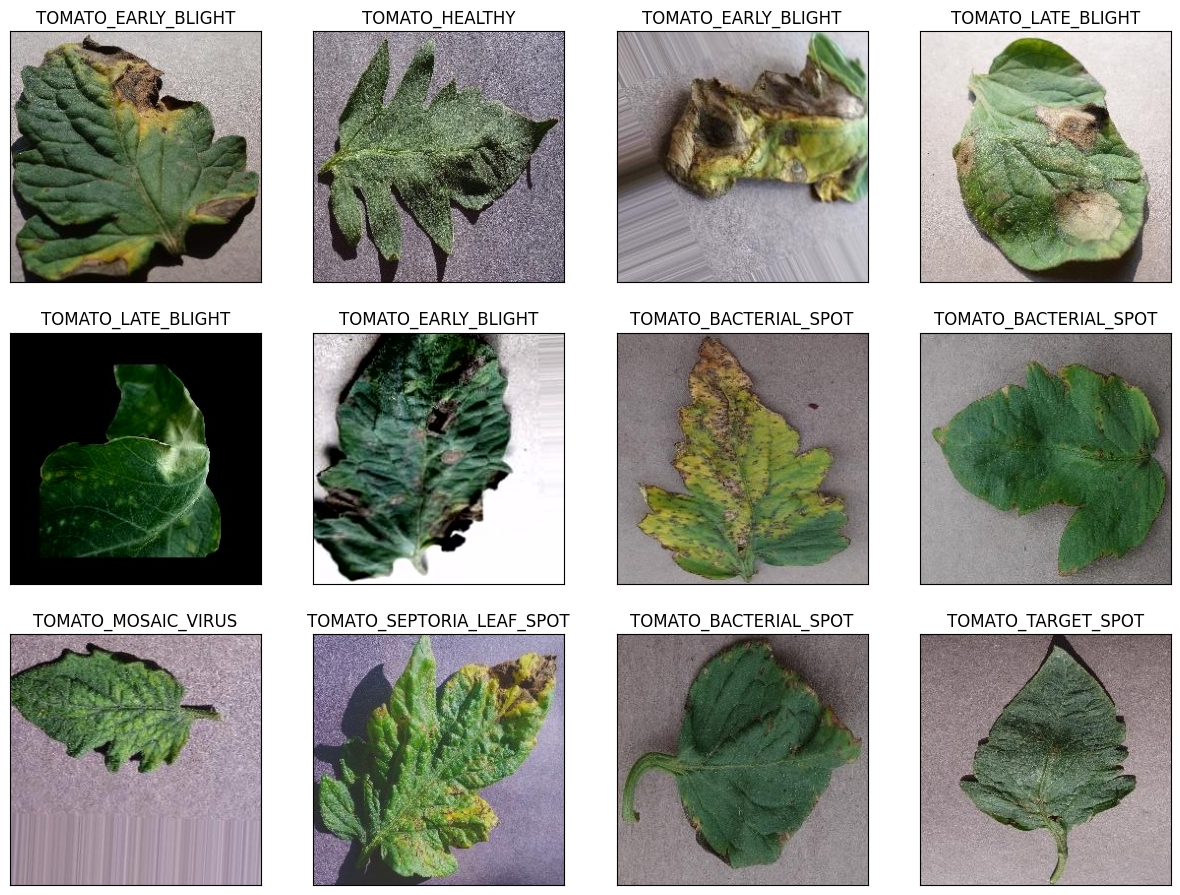

In [4]:
total_train_images = glob.glob('./output/train/*/*.jpg')
train_df = pd.DataFrame(pd.Series(total_train_images))

train_df['Filename'] = train_df[0].apply(lambda x: x.split('/')[-1])
train_df['class'] = train_df[0].apply(lambda x: x.split('/')[-2])

plot_df = train_df.sample(12).reset_index()

plt.figure(figsize = (15,15))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    class_str = plot_df.loc[i, 'class']
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(os.path.join(FILE_PATH, class_str, img_name)))
    plt.title(class_str)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
# train_datagen = ImageDataGenerator(zoom_range= 0.15, width_shift_range= 0.2, height_shift_range= 0.2, shear_range= 0.10)
# test_datagen = ImageDataGenerator()
# val_datagen = ImageDataGenerator()

# train_generator = train_datagen.flow_from_directory(
#     train_path, target_size = (256,256),
#     batch_size = 32,
#     shuffle = True
# )

# test_generator = test_datagen.flow_from_directory(
#     test_path, target_size = (256, 256),
#     batch_size = 32,
#     shuffle = False
# )

# val_generator = val_datagen.flow_from_directory(
#     val_path, target_size = (256,256),
#     batch_size = 32,
#     shuffle = False
# )

In [5]:
train_ds = tensorflow.keras.utils.image_dataset_from_directory(
    train_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = True
)

test_ds = tensorflow.keras.utils.image_dataset_from_directory(
    test_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False
)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
    val_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False
)

AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)

Found 165679 files belonging to 8 classes.


I0000 00:00:1757186285.189355   28020 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6


Found 20718 files belonging to 8 classes.
Found 20707 files belonging to 8 classes.


# ResNet50

In [6]:
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [11]:
# for layer in base_model.layers:
#     layer.trainable = False

In [12]:
# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation = 'relu')(x)
# predictions = Dense(8, activation = 'softmax')(x)

# model = Model(inputs = base_model.input, outputs = predictions)

In [7]:
inputs = Input(shape = (256,256,3))
x = tensorflow.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training = False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation= 'relu')(x)
outputs = Dense(8, activation = 'softmax', dtype = 'float32')(x)
model_rn50 = Model(inputs, outputs)

In [8]:
model_rn50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 256, 256,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │      2,056 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
model_rn50.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [10]:
history_rn50 = model_rn50.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2025-09-06 15:22:21.463070: I external/local_xla/xla/service/service.cc:163] XLA service 0x7934a4002de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-06 15:22:21.463163: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-06 15:22:21.876097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-06 15:22:23.300835: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-06 15:22:23.576173: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-06 15:22:24.356182: I e

5178/5178 ━━━━━━━━━━━━━━━━━━━━ 410s 76ms/step - accuracy: 0.8848 - loss: 0.3774 - val_accuracy: 0.9605 - val_loss: 0.1128
Epoch 2/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 394s 76ms/step - accuracy: 0.9315 - loss: 0.1990 - val_accuracy: 0.9685 - val_loss: 0.0984
Epoch 3/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 415s 80ms/step - accuracy: 0.9407 - loss: 0.1725 - val_accuracy: 0.9617 - val_loss: 0.1125
Epoch 4/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 418s 81ms/step - accuracy: 0.9463 - loss: 0.1577 - val_accuracy: 0.9677 - val_loss: 0.0887
Epoch 5/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 421s 81ms/step - accuracy: 0.9505 - loss: 0.1463 - val_accuracy: 0.9792 - val_loss: 0.0624
Epoch 6/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 421s 81ms/step - accuracy: 0.9541 - loss: 0.1365 - val_accuracy: 0.9811 - val_loss: 0.0559
Epoch 7/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 418s 81ms/step - accuracy: 0.9559 - loss: 0.1332 - val_accuracy: 0.9803 - val_loss: 0.0579
Epoch 8/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 404s 78ms/step - accuracy: 0.9572 - lo

# MobileNet V2

In [11]:
base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
inputs = Input(shape = (256,256,3))
x = tensorflow.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training = False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation= 'relu')(x)
outputs = Dense(8, activation = 'softmax', dtype = 'float32')(x)
model_mnv2 = Model(inputs, outputs)

In [14]:
model_mnv2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
model_mnv2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [15]:
history_mnv2 = model_mnv2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2025-09-06 16:30:57.689603: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-06 16:30:58.860854: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4682', 520 bytes spill stores, 520 bytes spill loads



5178/5178 ━━━━━━━━━━━━━━━━━━━━ 199s 34ms/step - accuracy: 0.8026 - loss: 0.5794 - val_accuracy: 0.8929 - val_loss: 0.3075
Epoch 2/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 151s 29ms/step - accuracy: 0.8516 - loss: 0.4198 - val_accuracy: 0.8929 - val_loss: 0.3102
Epoch 3/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 151s 29ms/step - accuracy: 0.8661 - loss: 0.3799 - val_accuracy: 0.9103 - val_loss: 0.2605
Epoch 4/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 151s 29ms/step - accuracy: 0.8744 - loss: 0.3573 - val_accuracy: 0.9079 - val_loss: 0.2681
Epoch 5/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 150s 29ms/step - accuracy: 0.8788 - loss: 0.3438 - val_accuracy: 0.9108 - val_loss: 0.2535
Epoch 6/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 150s 29ms/step - accuracy: 0.8838 - loss: 0.3311 - val_accuracy: 0.9272 - val_loss: 0.2105
Epoch 7/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 150s 29ms/step - accuracy: 0.8852 - loss: 0.3270 - val_accuracy: 0.9207 - val_loss: 0.2214
Epoch 8/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 150s 29ms/step - accuracy: 0.8875 - lo

# Gráfica de comparación

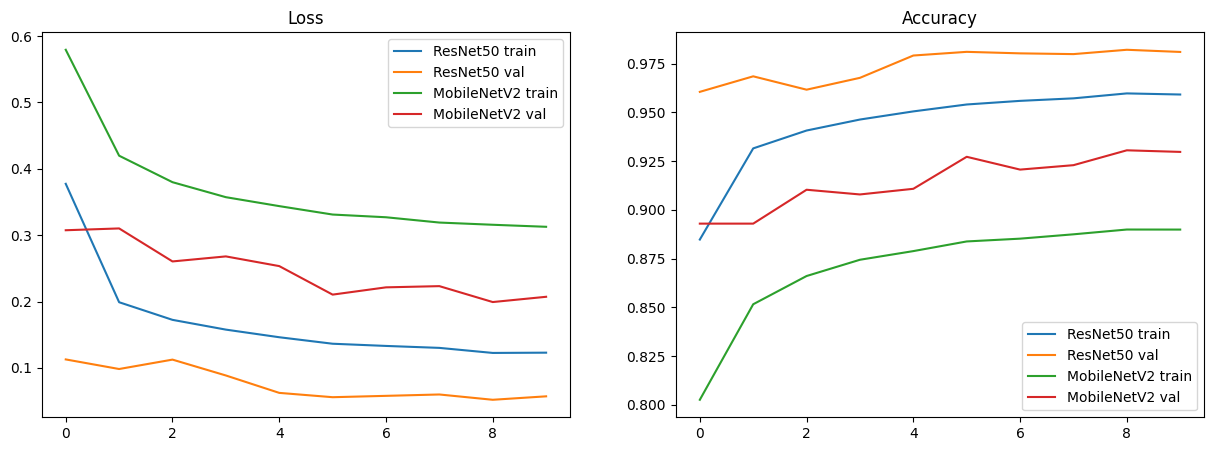

In [16]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1);plt.plot(history_rn50.history['loss'], label = 'ResNet50 train');plt.plot(history_rn50.history['val_loss'], label = 'ResNet50 val');
plt.plot(history_mnv2.history['loss'], label = 'MobileNetV2 train');plt.plot(history_mnv2.history['val_loss'], label = 'MobileNetV2 val');
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2);plt.plot(history_rn50.history['accuracy'], label = 'ResNet50 train');plt.plot(history_rn50.history['val_accuracy'], label = 'ResNet50 val');
plt.plot(history_mnv2.history['accuracy'], label = 'MobileNetV2 train');plt.plot(history_mnv2.history['val_accuracy'], label = 'MobileNetV2 val');
plt.legend()
plt.title('Accuracy')
plt.show()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def report(data_ds, class_names = None, model = None, verbose = 0) -> None:

    if model is None:
        try:
            _:model.summary
        except NameError:
            raise ValueError("Debería pasa 'model' explícitamente")

    y_true = []
    y_pred = []

    for batch_x, batch_y in data_ds:
        preds = model.predict(batch_x)
        y_pred.extend(np.argmax(preds, axis = 1))

        by = batch_y.numpy()
        if by.ndim == 2:
            y_true.extend(np.argmax(by, axis = 1))
        else:
            y_true.extend(by.astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if class_names is None:
        n_classes = int(max(y_true.max(), y_pred.max()) + 1)
        class_names = [f"class_{i}" for i in range(n_classes)]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names, yticklabels=class_names,
        ylabel='True label', xlabel='Predicted label',
        title='Confusion Matrix'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/

2025-09-06 16:58:51.894799: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


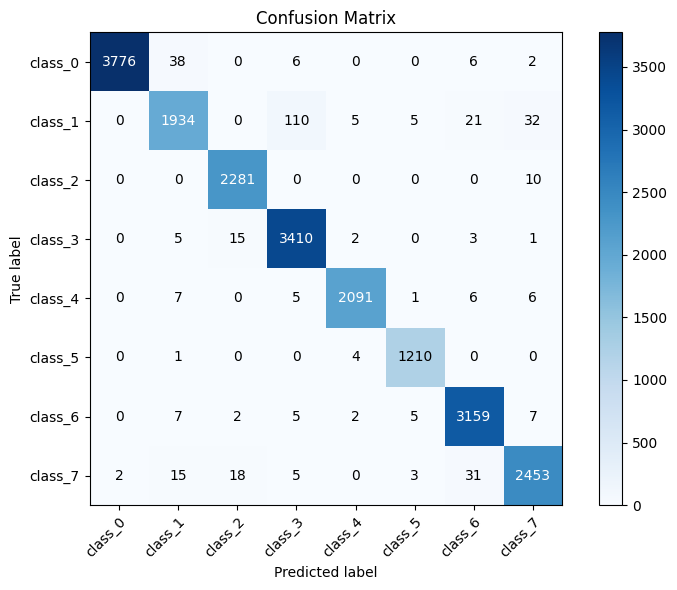

In [18]:
report(val_ds, model = model_rn50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

2025-09-06 17:00:20.083483: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


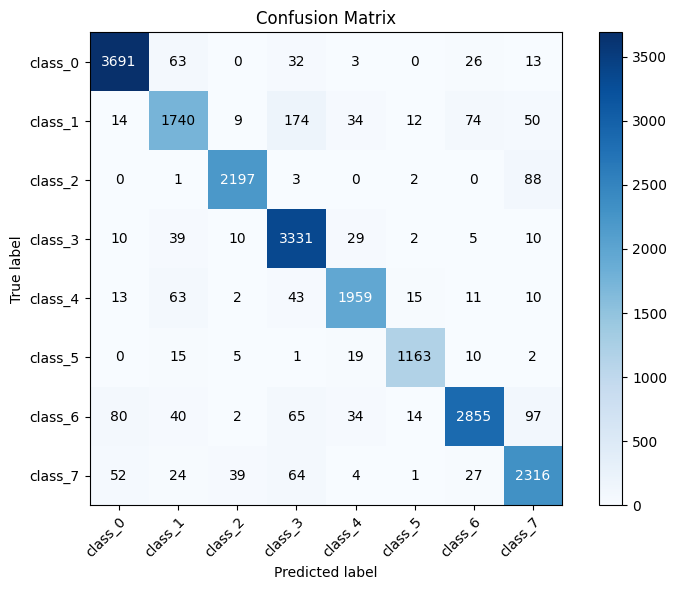

In [19]:
report(val_ds, model = model_mnv2)

In [20]:
for images, labels in test_ds.take(1):
    print(f"Batch size: {images.shape}")
    print(f"Labels: {labels}")

    preds = model_rn50.predict(images)
    pred_classes = preds.argmax(axis = 1)

Batch size: (32, 256, 256, 3)
Labels: [[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

def predict_single(model, dataset, class_names=None, index=None, verbose=0):

    for img, labs in dataset.take(1):
        batch_size = img.shape[0]

    if index is None:
        # Get the total number of samples in the dataset
        num_samples = tf.data.experimental.cardinality(dataset).numpy() * dataset.element_spec[0].shape[0]
        index = random.randint(0, num_samples - 1)

    # Find the batch and index within the batch for the selected sample
    batch_index = index // batch_size
    sample_index_in_batch = index % batch_size

    # Get the specific batch
    for i, (imgs, labs) in enumerate(dataset):
        if i == batch_index:
            img = imgs[sample_index_in_batch]
            label = labs[sample_index_in_batch]
            break

    # Model expects a batch
    img_batch = tf.expand_dims(img, axis=0)

    preds = model.predict(img_batch, verbose=verbose)
    pred_class_idx = np.argmax(preds, axis=1)[0]

    # True label index
    if label.ndim > 0 and label.shape[-1] > 1:   # one-hot vector
        true_idx = np.argmax(label.numpy())
    else:
        true_idx = int(label.numpy())

    # Show the image
    plt.imshow(img.numpy().astype("uint8"))
    if class_names:
        plt.title(f"True: {class_names[true_idx]} | Pred: {class_names[pred_class_idx]}")
    else:
        plt.title(f"True idx: {true_idx} | Pred idx: {pred_class_idx}")
    plt.axis("off")
    plt.show()

    if class_names:
        print(f"True label: {class_names[true_idx]} (index {true_idx})")
        print(f"Predicted : {class_names[pred_class_idx]} (index {pred_class_idx})")
    else:
        print(f"True label index: {true_idx}")
        print(f"Predicted index : {pred_class_idx}")

2025-09-06 17:08:39.131182: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 30934016 bytes after encountering the first element of size 30934016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


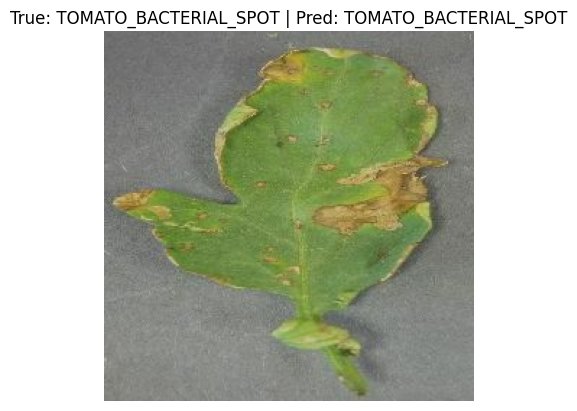

True label: TOMATO_BACTERIAL_SPOT (index 0)
Predicted : TOMATO_BACTERIAL_SPOT (index 0)


2025-09-06 17:08:39.602555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 30934016 bytes after encountering the first element of size 30934016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-09-06 17:08:39.610643: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


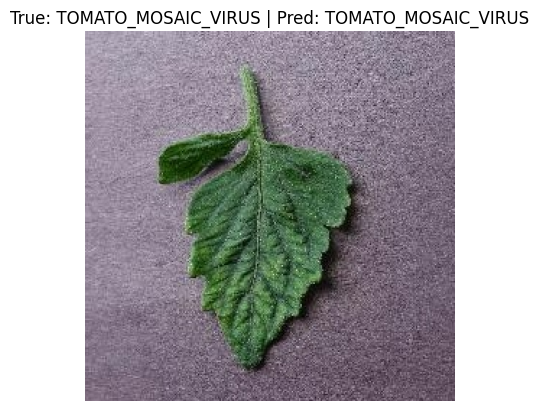

True label: TOMATO_MOSAIC_VIRUS (index 5)
Predicted : TOMATO_MOSAIC_VIRUS (index 5)


In [34]:
# assuming you already created test_ds and stored class_names before prefetching:
class_names = test_ds.class_names

# Show and predict sample number 5
predict_single(model_rn50, test_ds, class_names, index=5)
predict_single(model_rn50, test_ds, class_names, index=15000)


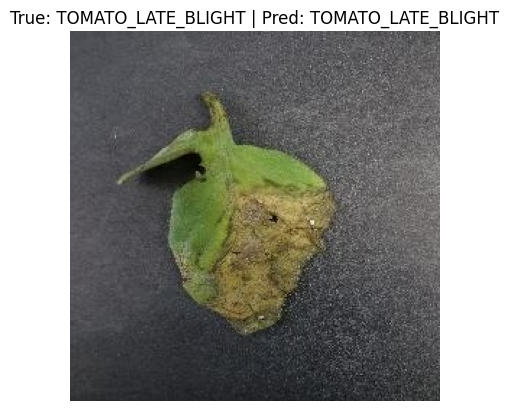

True label: TOMATO_LATE_BLIGHT (index 3)
Predicted : TOMATO_LATE_BLIGHT (index 3)


In [31]:
# assuming you already created test_ds and stored class_n
#prefetching:
class_names = test_ds.class_names

# Show and predict sample number 5
predict_single(model_mnv2, test_ds, class_names, index = 10000)